<a href="https://colab.research.google.com/github/apandit42/cs229tings/blob/master/Daniel_workspace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import Statements
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

In [ ]:
def mean_var_Normalizatiton(feature):
  return (feature - np.mean(feature)) / np.var(feature)


# L1 regularization for linear model, returns computed alphas,

def lassoRegularization(features, labels):
  return sk.linear_model.lasso_path(fetatures, labels)


# Scaling training data to lie within [min, max] ([0, 1] by default)
# good for scaling sparse data/data centered at zero
def minMaxScaler(features, min = 0, max = 1):
  scaler = sk.preprocessing.MinMaxScaler((min, max))
  return scaler.transform(features)


# Scaling training data to lie within [min, max] ([0, 1] by default)
# good for scaling sparse data/data centered at zero
def maxAbsScaler(features, min = -1, max = 1):
  scaler = sk.preprocessing.MaxAbsScaler((min, max))
  return scaler.transform(features)


# Mapping to Gaussian distribution. Good for non linear models such
# as GDA and kernel methods. Set standardization = True to standardize
# to unit variance and zero mean. 
def GaussianMap(features, standardization = False):
  pt = sk.preprocessing.PowerTransformer(method='box-cox', 
                                      standardize = standardization)
  return pt.fit_transform(features)


# Normalization by L1/L2 regularization to obtain unit norm for 
# individual samples
def normalization(features, normType):
  return sk.preprocessing.normalize(features, norm = normType)
  

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize


def multiclassROC(y_truth, clf, X_test):
  pred_y = clf.predict_proba(X_test)
  fig = plt.figure()
  # dictionary of data for each label
  datax = {}
  datay = {}
  for i in range(3):
    roc = metrics.roc_curve(y_truth, pred_y.T[i], pos_label = i)
    datax[i] = roc[0]     # false positive
    datay[i] = roc[1]     # true positive
  i = 0
  for key in datax:
    plt.plot(datax[key], datay[key], label = f"Label {i}")
    i += 1
  plt.title("False Positive Rate vs True Positive Rate for Each Label")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend()


clf = pickle.load(open("/content/clf.p", mode="rb"))
xts = pickle.load(open("/content/xts.p", mode="rb"))   
y_truth = pickle.load(open("/content/yts.pickle", mode="rb"))
multiclassROC(y_truth, clf, xts)


FileNotFoundError: ignored

In [33]:
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import dummy
from sklearn import tree
from sklearn import neighbors
from sklearn import discriminant_analysis
from sklearn import svm

In [34]:
class ModelValidator():
  fig_size = (5,4)

  def __init__(self, features, labels, groups):
    self.X = features.copy()  # Features
    self.Y = labels.copy()  # Labels
    self.groups = groups.copy()  # PlayeId DataSeries
    self.model_balanced_accuracies = [] # balanced accuracy of model
    self.model_accuracies = []      # each model's precision


  def color_model_stats(self, name, clf, target_type):
    kf = model_selection.GroupKFold(n_splits=5)
    all_yts = None
    all_y_pred = None
    all_y_prob = None
    
    pred_func_dict = {
        'Dummy': 'proba',
        'GaussianNB': 'proba',
        'LogisticRegression': 'proba',
        'DecisionTree': 'proba',
        'KNN': 'proba',
        'LDA': 'proba',
        'Ridge': 'deci',
        'SVM-SVC': 'deci',
        'LinearSVC': 'deci',
    }

    name_prob = pred_func_dict[name]


    for train, test in kf.split(self.X, self.Y, groups=self.groups):
      clf.fit(self.X.iloc[train], self.Y.iloc[train])
      y_pred = clf.predict(self.X.iloc[test])

      if name_prob == "proba":
        y_prob = clf.predict_proba(self.X.iloc[test])
      else:
        y_prob = clf.decision_function(self.X.iloc[test])

      if all_yts is None or all_y_pred is None:
        all_yts = self.Y.iloc[test]
        all_y_pred = pd.Series(y_pred)
        all_y_prob = pd.DataFrame(y_prob)
      else:
        all_yts = pd.concat([all_yts, self.Y.iloc[test]])
        all_y_pred = pd.concat([all_y_pred, pd.Series(y_pred)])
        all_y_prob = pd.concat([all_y_prob, pd.DataFrame(y_prob)])
    
    if name == 'Ridge' or name == 'LinearSVC':
      all_y_prob = np.exp(all_y_prob) / np.sum(np.exp(all_y_prob), axis=1)[:,None]

    if target_type == 'color':
      target_names = ['bronze', 'silver', 'gold']
        # grabs a dictionary of report
      report = metrics.classification_report(all_yts, all_y_pred, 
                                              target_names=target_names, output_dict=True)
      report = metrics.classification_report(all_yts, all_y_pred, target_names=target_names, output_dict=True)
      target_accuracies = []        # creates list of precisions
      for target_name in target_names:
        class_report = report[target_name]         # gets report for particular class
        target_accuracies.append(class_report['precision'])
      self.model_accuracies.append(target_accuracies) 
    
    self.model_balanced_accuracies.append(metrics.balanced_accuracy_score(all_yts, all_y_pred))    # balanced accuracy of model
    print(f"{name} Model Report (Avg):")
    print(metrics.classification_report(all_yts, all_y_pred, target_names=target_names))
    print(f"Balanced Accuracy: {metrics.balanced_accuracy_score(all_yts, all_y_pred)}")
    print(f"ROC AUC Values: {metrics.roc_auc_score(all_yts, all_y_prob, multi_class='ovr', average='weighted')}")
    

    for i in range(len(target_names)):
      fp, tp, thr = metrics.roc_curve(all_yts, all_y_prob.iloc[:,i], pos_label=i)
      sns.lineplot(x=fp, y=tp, ci=None, estimator=None, label=target_names[i])
    plt.legend()
    plt.title('ROC Curve')
    plt.ylabel('TP Rate')
    plt.xlabel('FP Rate')
    plt.tight_layout()
    

    plt.figure(figsize=ModelValidator.fig_size)
    for i in range(len(target_names)):
      pr, rc, thr = metrics.precision_recall_curve(all_yts, all_y_prob.iloc[:,i], pos_label=i)
      sns.lineplot(x=rc, y=pr, ci=None, estimator=None, label=target_names[i])
    plt.legend()
    plt.title('Precision Recall Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=ModelValidator.fig_size)
    confusion_matrix = metrics.confusion_matrix(all_yts, all_y_pred, normalize='all')
    sns.heatmap(confusion_matrix, annot=True).set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
  
  def player_color_rank(self, to_run=None):
    accuracies = []
    models = []
    if to_run is None or "gnb" in to_run:
      gauss_nb = naive_bayes.GaussianNB()
      self.color_model_stats("GaussianNB", gauss_nb, "color")
      models.append("Gaussian Naïve Bayes")

    if to_run is None or "logreg" in to_run:
      logreg = linear_model.LogisticRegression(solver="newton-cg", class_weight="balanced", max_iter=100000)
      self.color_model_stats("LogisticRegression", logreg, "color")
      models.append("Logistic Regression")

    if to_run is None or "dectree" in to_run:
      dectree = tree.DecisionTreeClassifier()
      self.color_model_stats("DecisionTree", dectree, "color")
      models.append("Decision Tree")
    if to_run is None or "knn" in to_run:
      knn = neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance')
      self.color_model_stats("KNN", knn, "color")
      models.append("K Nearest Neighbors")
    
    if to_run is None or "lda" in to_run:
      lda = discriminant_analysis.LinearDiscriminantAnalysis()
      self.color_model_stats("LDA", lda, "color")
      models.append("LDA")

    if to_run is None or "ridge" in to_run:
      ridge = linear_model.RidgeClassifier(normalize=True)
      self.color_model_stats("Ridge", ridge, "color")
      models.append("Ridge Classifier")

    # if to_run is None or "svm_svc" in to_run:
    #   svc = svm.SVC(kernel='sigmoid', probability=True, decision_function_shape='ovr')
    #   self.color_model_stats("SVM-SVC", svc, "color")
    #   models.append("SVM Classifier")
    
    # if to_run is None or "linear_svc" in to_run:
    #   linear_svc = svm.LinearSVC()
    #   self.color_model_stats('LinearSVC', linear_svc, "color")
    #   models.append("LinearSVC")

    # Plotting
    fig, ax = plt.subplots(figsize = (10,4))      # subplots of bar graphs
    precisions = self.model_accuracies
    balanced_acc = self.model_balanced_accuracies   
    n = len(models)       # nunmber of models ran
    colors = ["yellow",   # colors for plots
              "red", 
              "orange",
              "purple",
              "black",
              "green,"
              "blue"]
    idx = [0, 1, 2, 3]      # indices of four plotted stats
    for i in range(n):
      precisions[i].append(balanced_acc[i])
      x = precisions[i]
      ax.bar(idx, x, color = colors[i])     # plot for current model
      idx = [index + 4 for index in idx]    # update indices
    ax.set_xticks(range(n*4))               # sets ticks
    ax.set_xticklabels(["b prec", "s prec", "g prec", "bal acc"] * n, rotation=65)
    ax.legend(models[:n])
    fig.tight_layout()
    plt.show()

In [38]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pickle
import seaborn as sns
from sklearn import model_selection

RANDOM_SEED = 42069360
db = pd.read_csv('fifa_final.csv')
# Feature Set for Predicting Card Level / Color
card_level_db = db[db.min_played >= 90].copy()

# Card Labels for Level / Color
card_labels = card_level_db[["fifa_overall_category", "fifa_overall_score", "fifa_physical", "fifa_defense", "fifa_dribbling", "fifa_passing", "fifa_shooting", "fifa_pace"]]

card_oscore_lb = card_labels.fifa_overall_score
card_physical_lb = card_labels.fifa_physical
card_defense_lb = card_labels.fifa_defense
card_dribbling_lb = card_labels.fifa_dribbling
card_passing_lb = card_labels.fifa_passing
card_shooting_lb = card_labels.fifa_shooting
card_pace_lb = card_labels.fifa_pace

card_labels = card_level_db.fifa_overall_category.map({'bronze': 0, 'silver': 1, 'gold': 2})

# Card Features for Level / Color
card_level_db = pd.concat([card_level_db.iloc[:, 7:40].drop(columns=['ws_season']), card_level_db.iloc[:, -1]], axis=1)
card_features = card_level_db.drop(columns=['fifa_overall_category'])
card_features = pd.get_dummies(card_features, drop_first=True, columns=['ws_tournament_name', 'position'])

# Splitting training and testing data, hard 80/20 Split
train_card_features, test_card_features, train_card_labels, test_card_labels = model_selection.train_test_split(card_features, card_labels, test_size=0.2, random_state=RANDOM_SEED)

# Card Groups for Level / Color, Training
train_card_features = train_card_features.drop(columns=['ws_player_id']).copy()
train_data = train_card_features
# Card Groups for Level / Color, Testing
test_card_features = test_card_features.drop(columns=['ws_player_id'])

# EVERYTHING ELSE FEATURES
overall_card_labels = pd.concat([card_oscore_lb, card_physical_lb, card_defense_lb, card_dribbling_lb, card_passing_lb, card_shooting_lb, card_pace_lb],axis=1)
train_2nd_card_features, test_2nd_card_features, train_2nd_card_labels, test_2nd_card_labels = model_selection.train_test_split(card_features, overall_card_labels, test_size=0.2, random_state=RANDOM_SEED)

display(train_2nd_card_labels)

train_2nd_card_features = train_2nd_card_features.drop(columns=['ws_player_id']).copy()
test_2nd_card_features = test_2nd_card_features.drop(columns=['ws_player_id']).copy()
# Initialization of each training label set
overall_train_labels = train_2nd_card_labels.fifa_overall_score
physical_train_labels = train_2nd_card_labels.fifa_physical
defense_train_labels = train_2nd_card_labels.fifa_defense
dribbling_train_labels = train_2nd_card_labels.fifa_dribbling
passing_train_labels = train_2nd_card_labels.fifa_passing
shooting_train_labels = train_2nd_card_labels.fifa_shooting
pace_train_labels = train_2nd_card_labels.fifa_pace

# Initialization of each testing label set
overall_test_labels = test_2nd_card_labels.fifa_overall_score
physical_test_labels = test_2nd_card_labels.fifa_physical
defense_test_labels = test_2nd_card_labels.fifa_defense
dribbling_test_labels = test_2nd_card_labels.fifa_dribbling
passing_test_labels = test_2nd_card_labels.fifa_passing
shooting_test_labels = test_2nd_card_labels.fifa_shooting
pace_test_labels = test_2nd_card_labels.fifa_pace

db.describe()

fifa_overall_score  fifa_physical  ...  fifa_shooting  fifa_pace
10328                  70             62  ...             60         86
12781                  65             72  ...             63         54
6128                   76             75  ...             72         73
2147                   71             74  ...             68         68
14024                  80             67  ...             77         75
...                   ...            ...  ...            ...        ...
7914                   70             74  ...             64         84
16702                  69             80  ...             49         46
913                    58             65  ...             29         48
13705                  78             72  ...             67         77
6168                   73             68  ...             69         73

[15549 rows x 7 columns]

Unnamed: 0           id  ...  fifa_aggression  fifa_overall_score
count  20873.00000  20873.00000  ...     20873.000000         20873.00000
mean   10436.00000  10437.00000  ...        62.393092            71.80252
std     6025.66042   6025.66042  ...        16.665678             6.28183
min        0.00000      1.00000  ...        11.000000            47.00000
25%     5218.00000   5219.00000  ...        53.000000            68.00000
50%    10436.00000  10437.00000  ...        66.000000            72.00000
75%    15654.00000  15655.00000  ...        75.000000            76.00000
max    20872.00000  20873.00000  ...        96.000000            94.00000

[8 rows x 72 columns]

In [39]:
from sklearn import preprocessing
train_card_features = train_data
bink = preprocessing.MinMaxScaler()
#train_card_features = train_card_features.drop(columns=["subs_on", "man_of_match_per_game", "yellow_cards_per_game", "red_cards_per_game", "goal_own_per_game"])  # drop man of the match, subs on, yellow cards, red cards
#transformer = preprocessing.Normalizer()
#train_card_features.loc[:, ["age", "height", "weight", "pass_success", "fouls_per_game"]] = bink.fit_transform(train_card_features.loc[:, ["age", "height", "weight", "pass_success", "fouls_per_game"]])
#train_card_features.loc[:, :"total_passes_per_game"] = bink.fit_transform(train_card_features.loc[:, :"total_passes_per_game"])
chungus = ModelValidator(train_card_features, train_card_labels, train_card_groups)
chungus.player_color_rank()




NameError: ignored

In [ ]:
from sklearn import preprocessing
train_card_features = train_data
bink = preprocessing.MinMaxScaler()
#train_card_features = train_card_features.drop(columns=["subs_on", "man_of_match_per_game", "yellow_cards_per_game", "red_cards_per_game", "goal_own_per_game"])  # drop man of the match, subs on, yellow cards, red cards
#transformer = preprocessing.Normalizer()
#train_card_features.loc[:, ["age", "height", "weight", "pass_success", "fouls_per_game"]] = bink.fit_transform(train_card_features.loc[:, ["age", "height", "weight", "pass_success", "fouls_per_game"]])
train_card_features.loc[:, :"total_passes_per_game"] = bink.fit_transform(train_card_features.loc[:, :"total_passes_per_game"])
chungus = ModelValidator(train_card_features, train_card_labels, train_card_groups)
chungus.player_color_rank()

# PCA BROTHAMAN


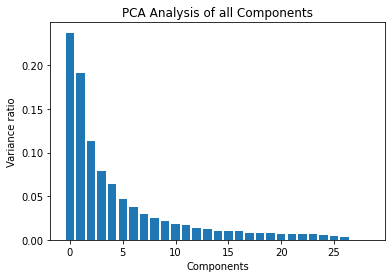

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 0 and 1


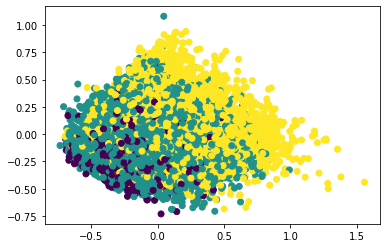

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 0 and 2


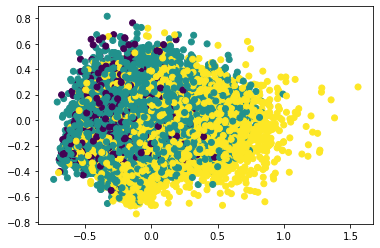

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 0 and 3


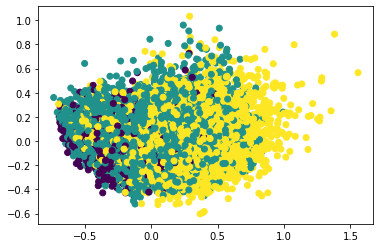

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 0 and 4


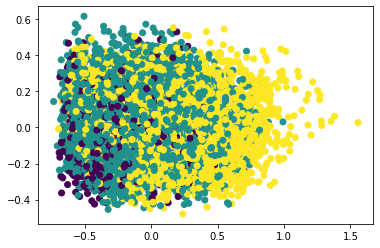

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 0 and 5


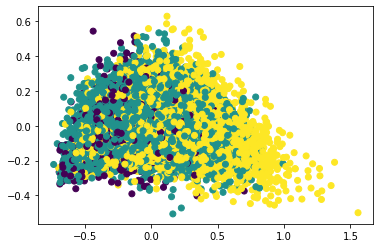

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 0 and 6


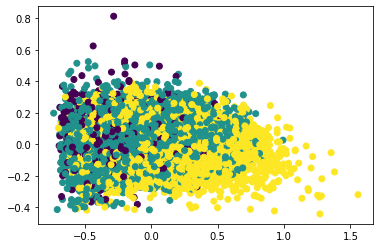

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 0 and 7


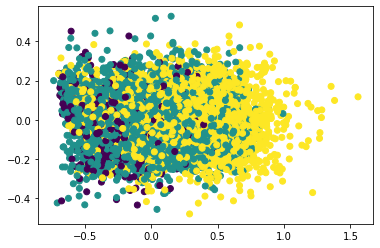

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 0 and 8


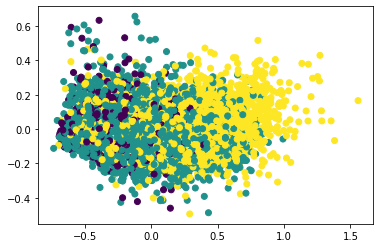

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 0 and 9


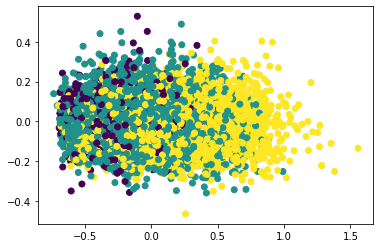

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 1 and 0


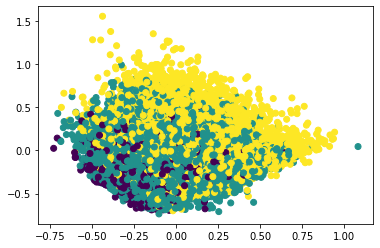

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 1 and 2


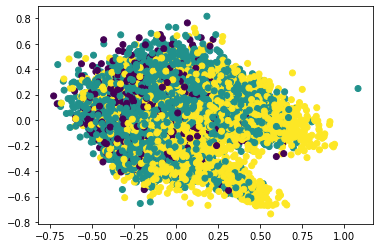

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 1 and 3


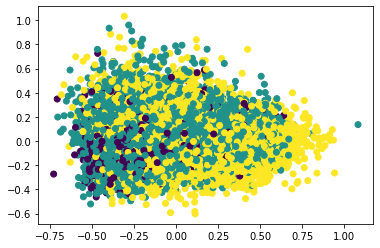

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 1 and 4


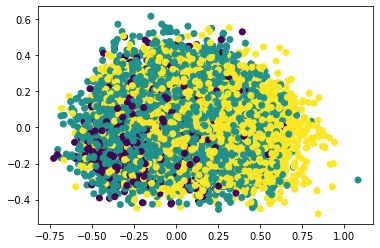

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 1 and 5


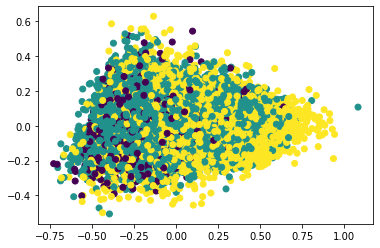

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 1 and 6


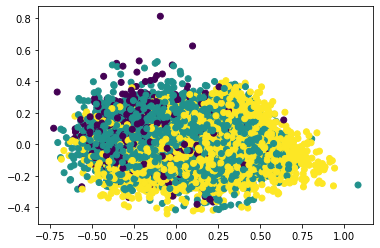

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 1 and 7


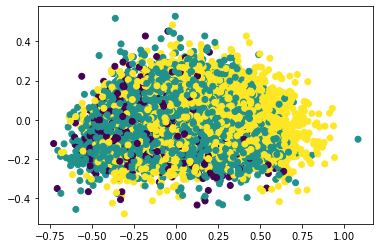

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 1 and 8


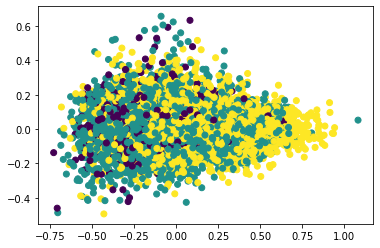

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 1 and 9


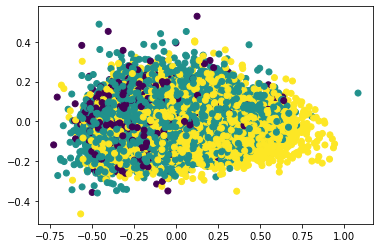

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 2 and 0


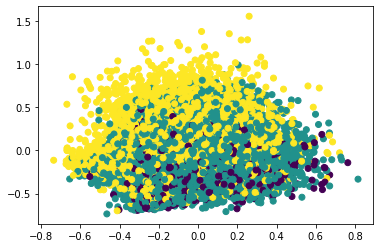

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 2 and 1


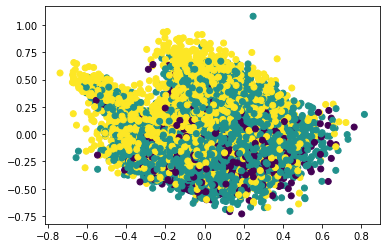

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 2 and 3


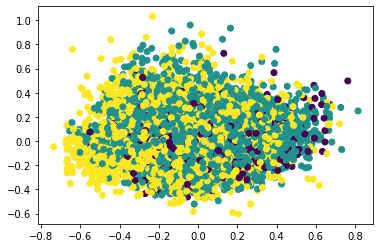

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 2 and 4


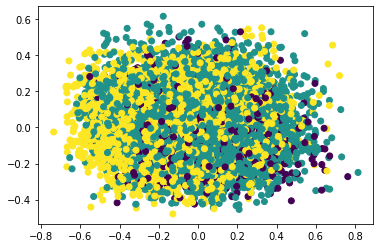

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 2 and 5


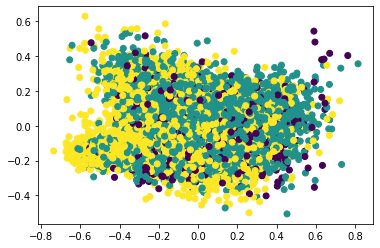

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 2 and 6


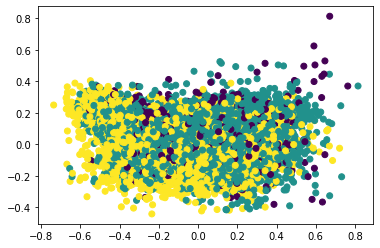

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 2 and 7


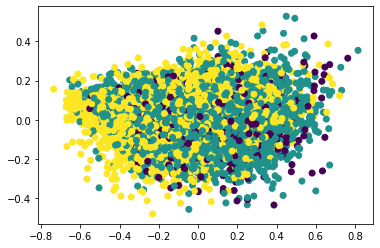

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 2 and 8


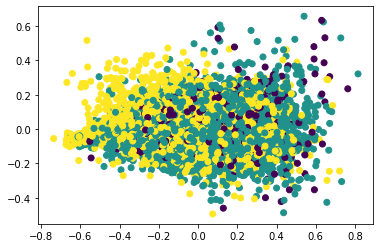

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 2 and 9


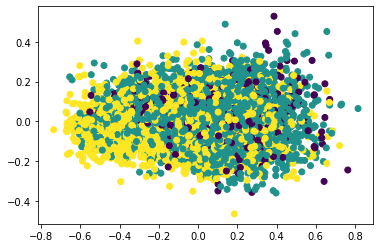

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 3 and 0


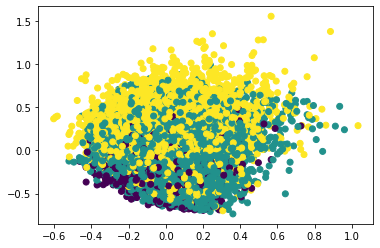

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 3 and 1


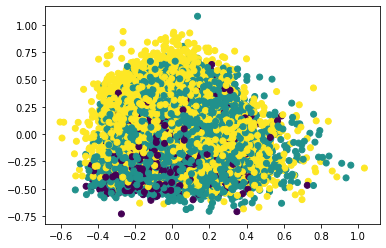

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 3 and 2


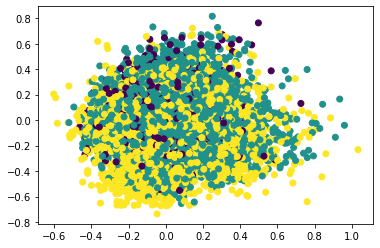

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 3 and 4


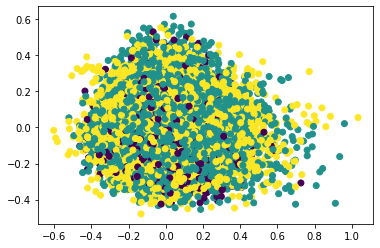

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 3 and 5


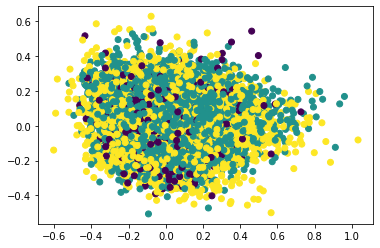

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 3 and 6


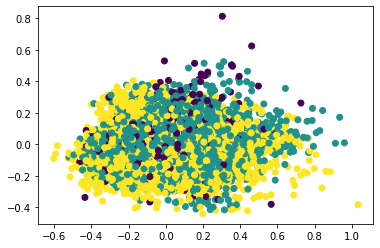

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 3 and 7


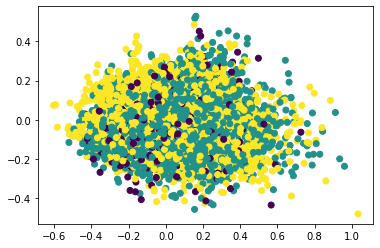

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 3 and 8


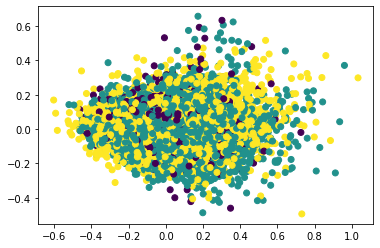

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 3 and 9


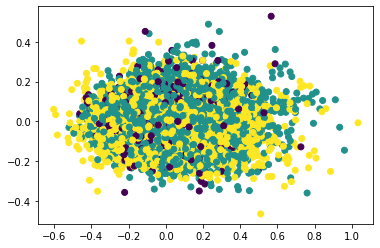

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 4 and 0


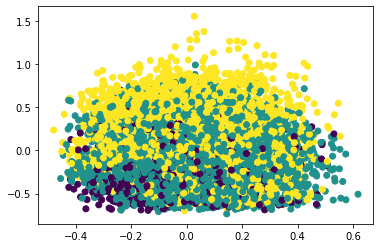

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 4 and 1


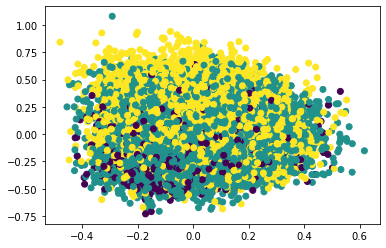

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 4 and 2


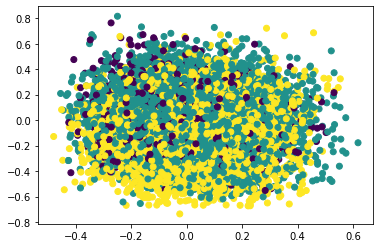

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 4 and 3


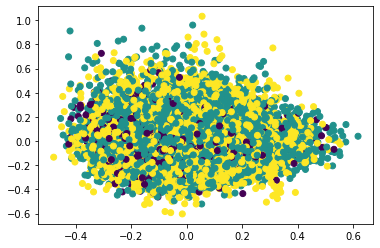

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 4 and 5


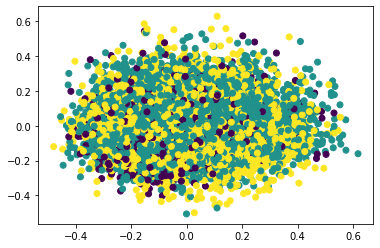

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 4 and 6


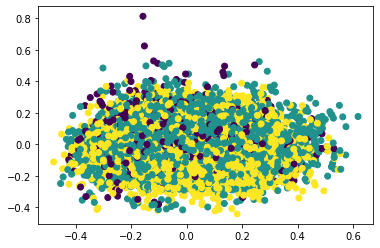

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 4 and 7


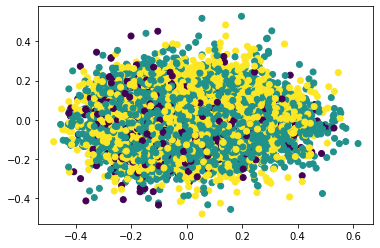

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 4 and 8


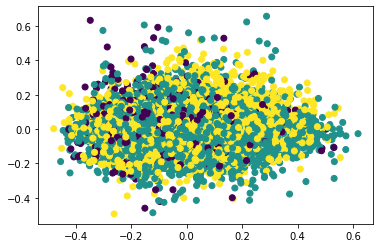

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 4 and 9


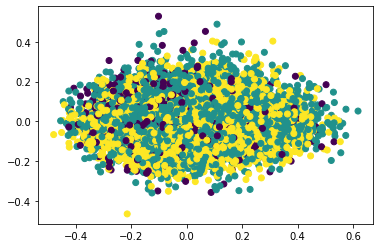

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 5 and 0


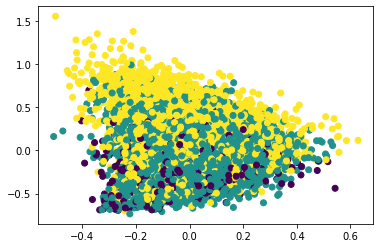

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 5 and 1


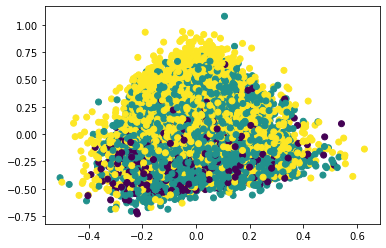

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 5 and 2


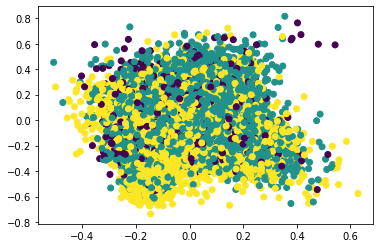

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 5 and 3


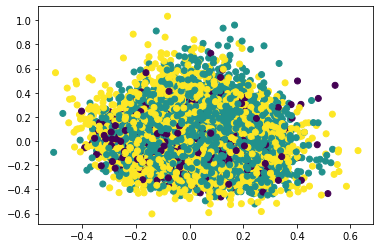

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 5 and 4


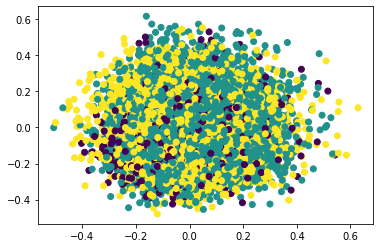

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 5 and 6


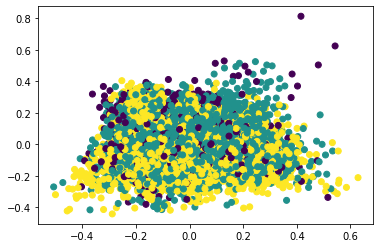

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 5 and 7


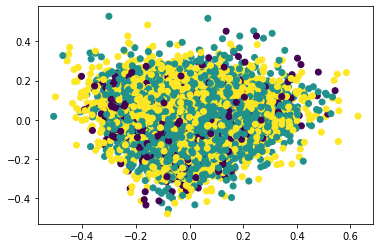

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 5 and 8


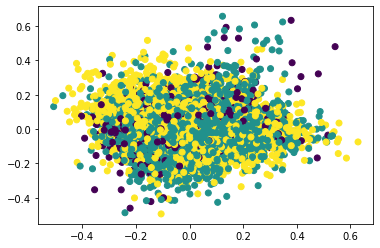

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 5 and 9


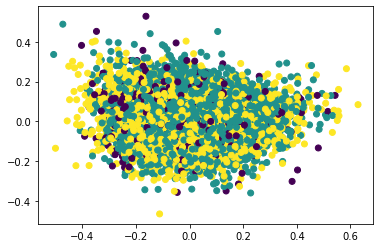

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 6 and 0


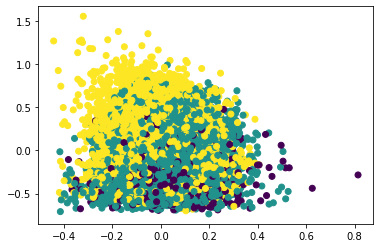

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 6 and 1


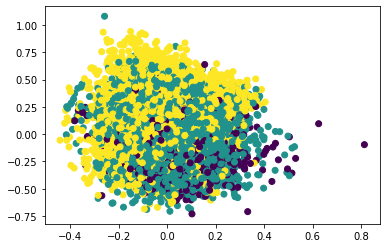

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 6 and 2


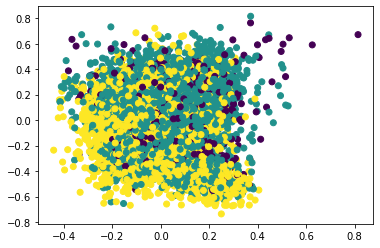

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 6 and 3


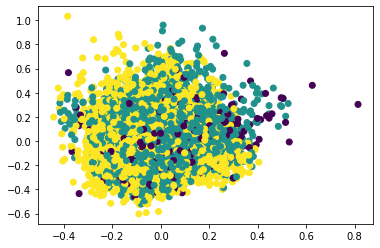

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 6 and 4


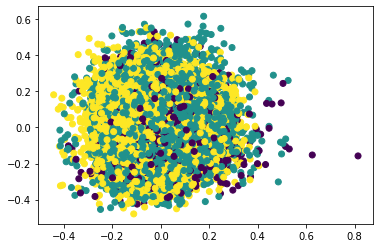

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 6 and 5


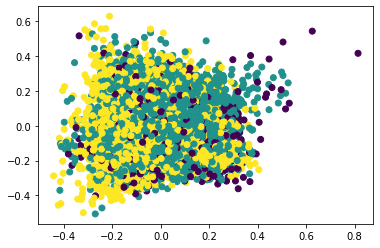

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 6 and 7


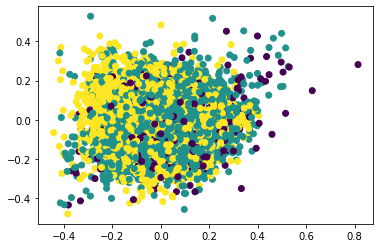

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 6 and 8


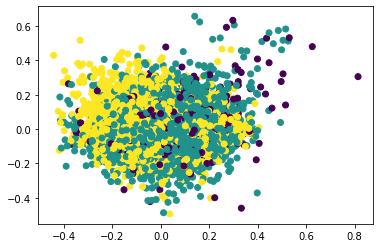

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 6 and 9


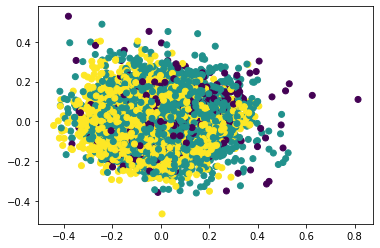

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 7 and 0


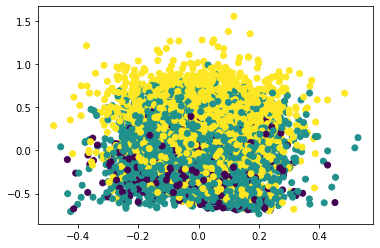

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 7 and 1


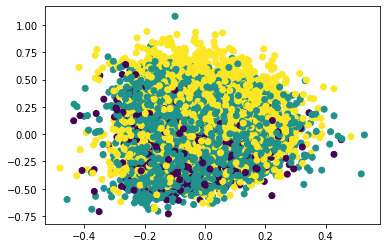

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 7 and 2


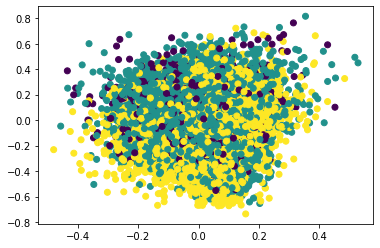

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 7 and 3


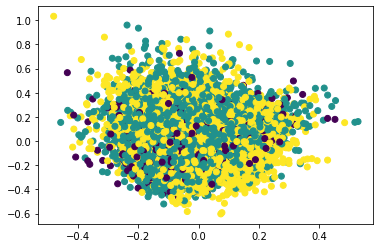

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 7 and 4


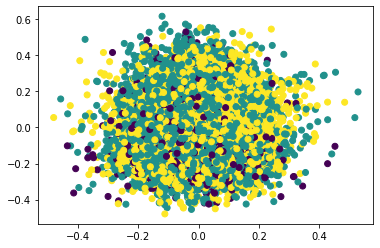

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 7 and 5


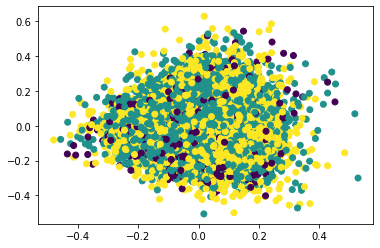

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 7 and 6


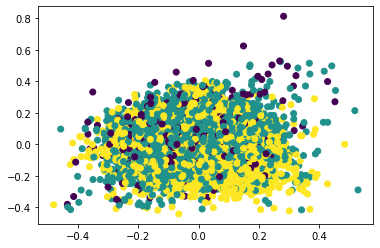

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 7 and 8


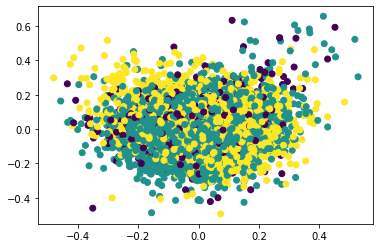

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 7 and 9


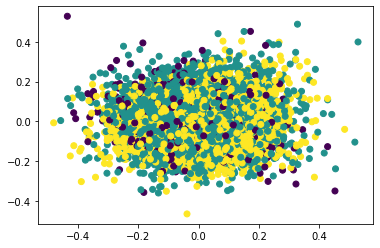

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 8 and 0


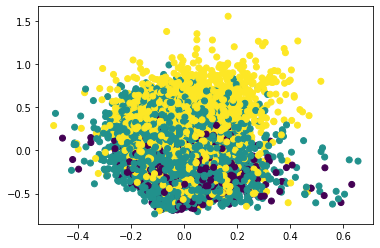

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 8 and 1


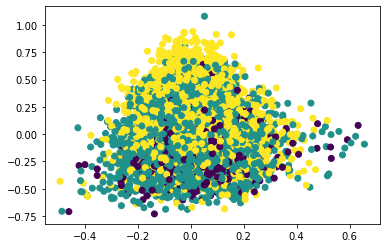

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 8 and 2


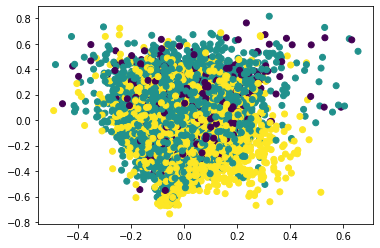

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 8 and 3


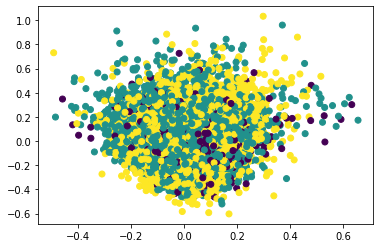

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 8 and 4


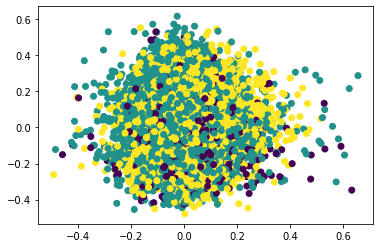

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 8 and 5


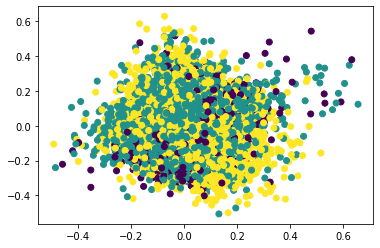

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 8 and 6


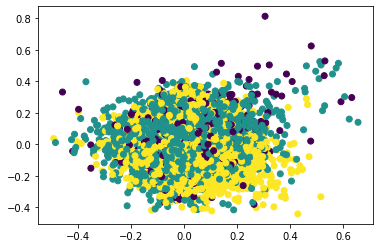

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 8 and 7


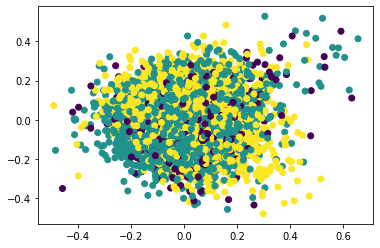

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 8 and 9


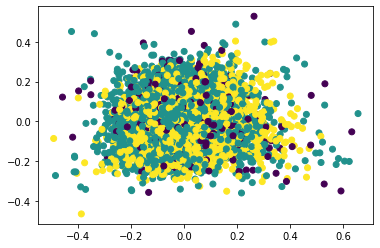

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 9 and 0


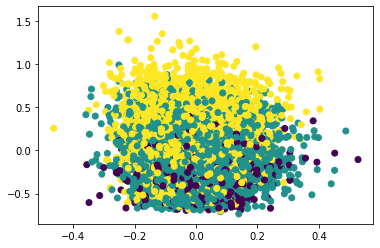

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 9 and 1


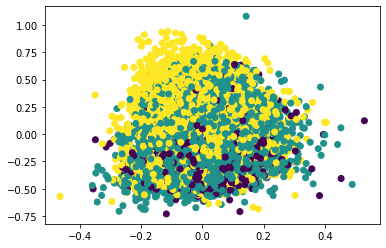

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 9 and 2


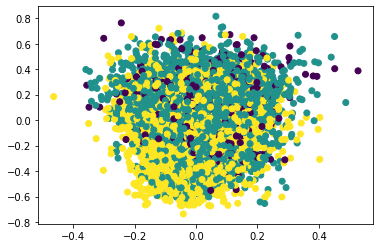

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 9 and 3


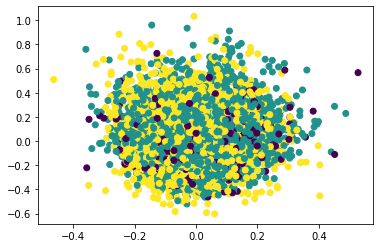

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 9 and 4


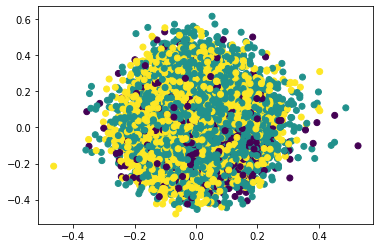

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 9 and 5


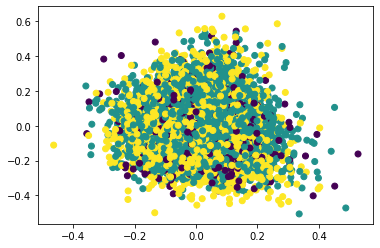

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 9 and 6


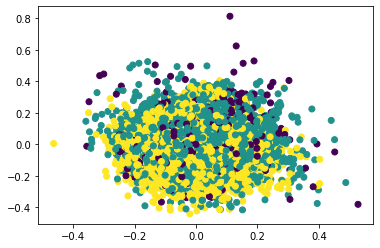

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 9 and 7


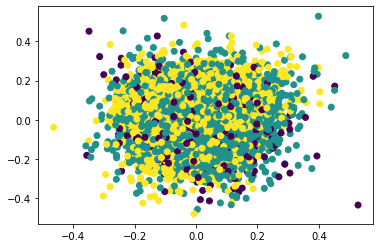

Shape of transformed features: (15549, 10)
Shape of normal features: (15549, 29)
Shape of labels: (15549,)
Feature plotted: 9 and 8


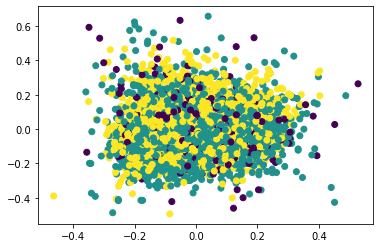

In [ ]:
from sklearn.decomposition import PCA
from sklearn import preprocessing


bink = preprocessing.MinMaxScaler()

pca = PCA()
x_train = bink.fit_transform(train_card_features.loc[:, :"total_passes_per_game"])
trans_gx = pca.fit_transform(x_train)

plt.figure()
plt.bar(range(x_train.shape[1]), pca.explained_variance_ratio_)
plt.ylabel('Variance ratio')
plt.xlabel('Components')
plt.title("PCA Analysis of all Components")
plt.savefig("jungus_wung_fungus.png")
plt.show()



#Plot with n = something
pca2 = PCA(n_components=10)
pca2.fit(x_train)
x_3d = pca2.transform(x_train)
labels = train_card_labels

for i in range(x_3d.shape[1]):
  for j in range(x_3d.shape[1]):
    if i == j:
      continue
    index_of_feature_1 = i
    index_of_feature_2 = j
    print(f"Shape of transformed features: {x_3d.shape}")
    print(f"Shape of normal features: {x_train.shape}")
    print(f"Shape of labels: {labels.shape}")
    print(f"Feature plotted: {index_of_feature_1} and {index_of_feature_2}")

    plt.figure()
    plt.scatter(x_3d[:,index_of_feature_1], x_3d[:,index_of_feature_2], c=labels)
    plt.show()



# Feature Selection

REF: [ 6  7  8 12]
1.25
1.0
1.0
1.0
K best: [ 3  5 10 28]
63
5028
6.45014245014245
109.0
L1 best feat: [ 6  7 12 25]
1.25
1.0
1.0
2.5945454545454547


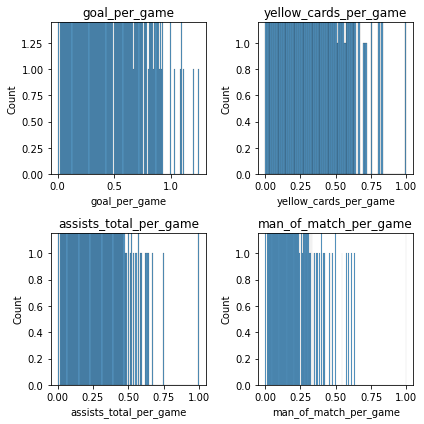

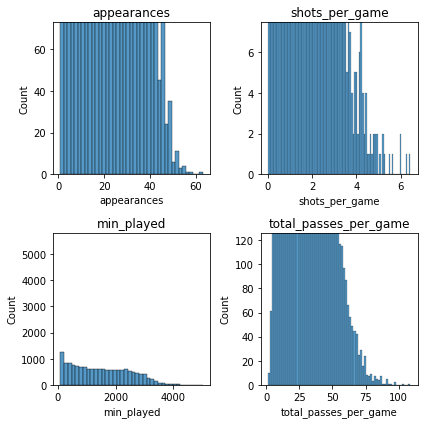

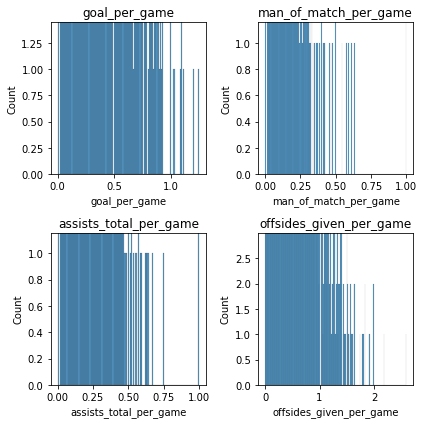

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
import seaborn as sns

def bestFeaturePlot(top_features, X, savepath):
  # plots distributions of n best features
  n = len(top_features)
  fig, axs = plt.subplots(n//2, n - n//2, figsize=(6, 6))
  iter_0 = 0 
  iter_1 = 0
  for j in range(n):
    index = top_features[j]
    feature = feature[X.iloc[:,index]>0]       # omits zero point data that skews plot
    # max = X.iloc[:, index].max()
    # print(max)
    # max = max + max/20
    feature = feature.iloc[:, index]
    sns.histplot(feature, ax = axs[iter_0, iter_1])
    axs[iter_0, iter_1].set_title(X.columns.to_list()[index])
    axs[iter_0, iter_1].set_ylim(top = max + max/10)    
    iter_0 += 1
    if iter_0 == n//2:
      iter_0 = 0
      iter_1 += 1
  plt.tight_layout()
  plt.savefig(savepath)


"""Must pass in the ML modelm, the number of features you want to determine,
the method of calculation of those best features, the training data with binary
features removed, and the corresponding labels."""
def bestFeatureSelect(num_features, clf, train_data, labels, method = "all"):
  if method == "all":
    selection = RFE(clf, num_features)
    selector = selection.fit(train_data, labels)     # fit data using clf
    top_features = selector.get_support(True)
    print(f"REF: {top_features}")
    bestFeaturePlot(top_features, train_data, "best_feat_RFE.png")

    X_best = SelectKBest(chi2, k=num_features).fit(train_data, labels)
    top_features = X_best.get_support(True)
    print(f"K best: {top_features}")
    bestFeaturePlot(top_features, X, "K_best_feat.png")

    L1_best_feat = SelectFromModel(clf, max_features = num_features)
    L1_best_feat = L1_best_feat.fit(train_data, labels)
    top_features = L1_best_feat.get_support(True)
    print(f"L1 best feat: {top_features}")
    bestFeaturePlot(top_features, X, "L1_best_feat.png")

  elif method == "REF":
    # # Recursive Feature Elimination Method
    selection = RFE(clf, num_features)
    selector = selection.fit(train_data, labels)     # fit data using clf
    top_features = selector.get_support(True)            # gets indices of top features
    print(f"REF: {top_features}")
    bestFeaturePlot(top_features, X)

  elif method == "KBest":
    # # Best K Features Method
    X_best = SelectKBest(chi2, k=num_features).fit(train_data, labels)
    top_features = X_best.get_support(True)
    print(f"K best: {top_features}")
    bestFeaturePlot(top_features, X)

  elif method == "L1Select":
    # L1 Based Feature Selection
    L1_best_feat = SelectFromModel(clf, max_features = n)
    L1_best_feat = L1_best_feat.fit(train_data, labels)
    top_features = L1_best_feat.get_support(True)
    print(f"L1 best feat: {top_features}")
    bestFeaturePlot(top_features, X)


# # Removing binary labels from data
X = train_data.loc[:, : "total_passes_per_game"]
y = train_card_labels
# # Parameters definition
n = 4 
clf = LogisticRegression(solver="newton-cg", class_weight="balanced", max_iter=100000)
bestFeatureSelect(4, clf, X, y)

# Neural Net Jungus

In [ ]:
from sklearn.neural_network import MLPRegressor


# Regression Metrics Implementation

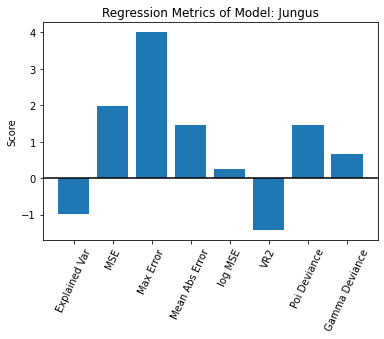

In [25]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

def regressionMetric(y_truth, y_predic, bar_width = 0.8, model_name = "Jungus"):
  var_score = metrics.explained_variance_score(y_truth, y_predic)       # explained variance score
  RMSE = metrics.mean_squared_error(y_truth, y_predic, squared=False)             # root means squared error
  max_error = metrics.max_error(y_truth, y_predic)                  # max error of model
  MAB = metrics.mean_absolute_error(y_truth, y_predic)              # mean absolute error
  MSElog = metrics.mean_squared_log_error(y_truth, y_predic)        # means squared log error
  # r2 scores averaged with variance weight
  var_weighted_r2 = metrics.r2_score(y_truth, y_predic, multioutput='variance_weighted')     # can also output uniform average/raw scores
  poisson_deviance = metrics.mean_tweedie_deviance(y_truth, y_predic, power=1)         # avg poisson deviance
  gamma_deviance = metrics.mean_tweedie_deviance(y_truth, y_predic, power=2)          # avg gamma deviance
  fig = plt.figure()
  ax = fig.add_subplot(111)
  y = [var_score, RMSE, max_error, MAB, MSElog, var_weighted_r2, poisson_deviance, gamma_deviance]
  x = [i for i in range(len(y))]
  plt.bar(x, y, width=bar_width)
  ax.axhline(0, color="black")
  plt.title(f"Regression Metrics of Model: {model_name}")
  plt.xticks(np.arange(len(y)), ["Explained Var", "MSE", "Max Error", "Mean Abs Error", "log MSE", "VR2", "Poi Deviance", "Gamma Deviance"], rotation=65)
  plt.ylabel("Score")
  plt.show()
regressionMetric([3, 4, 6, 2, 5, 4, 6, 5, 5, 6, 3, 5,6], [4, 2, 6, 5, 5, 1, 4, 5, 5, 2, 1, 3,6])

# Regression Implementation

In [31]:
from sklearn.neighbors import KNeighborsRegressor
import sklearn.linear_model as lm
import sklearn.ensemble as ensemble
from sklearn.kernel_ridge import KernelRidge

class OverallRegressionModelValidator(ValidatorWrapper):
  ### CODE NOT WORKING UNSURE WHAT THE PROBLEM IS ####
  def __init__(self, train_features, train_labels, test_features, test_labels):
    super().__init__(train_features, train_labels, test_features, test_labels)
    # training data init
    self.x_train, self.y_train = (train_features.copy(), train_labels.copy())
    # test data init
    self.x_test = test_features.copy()
    self.y_test = test_labels.copy()
    # list of all models
    self.models = ['KNeighbors','Tweedie','Gamma','Poisson','SGDRegressor','RidgeRegressr','GradientBoostingRegressor','BaggingRegressor', 'AdaBoostRegressor', 'KernelRidge', 'PLSRegression']
  
  def light_stats(self, name, clf_fit):
    yp = clf.predict(self.x_test)
    yp = pd.DataFrame(yp)

    # Plotting Regression Metrtics
    regressionMetric(self.y_test, yp, model = name)

    
  
  def player_overall_rank(self, to_run=None):
    # K neighbors regression
    if to_run is None or self.models[0] in to_run:
      # hyperparameters that can be tuned
      n_neighbors =  0                  
      weights = 'unifomrm'
      leaf_size = 30
      clf_fit = KNeighborsRegressor().fit(self.x_train, self.y_train)
      self.light_stats(self.models[0], clf_fit)

    # Tweedie Regressor
    if to_run is None or self.models[1] in to_run:
      # hyperparameters that can be tuned 
      aplha = 1.0 
      max_iter = 100
      power = 0     # parameter determined underlying target distribution

      clf_fit = lm.TweedieRegressor().fit(self.x_train, self.y_train)
      self.light_stats(self.models[1], clf_fit)

    # Gamma Regressor
    if to_run is None or self.models[2] in to_run:
      alpha = 1
      max_iter = 100

      clf_fit = lm.GammaRegressor().fit(self.x_train, self.y_train)
      self.light_stats(self.models[2], clf_fit)

    # Poisson Regressor
    if to_run is None or self.models[3] in to_run:
      # hyperparameters
      alpha = 0
      max_iter = 100

      clf_fit = lm.PoissonRegressor().fit(self.x_train, self.y_train)
      self.light_stats(self.models[3], clf_fit)
    
    # SGD Regressor
    if to_run is None or self.models[4] in to_run:
      # hyperparameters
      loss = "squared_loss"       # define loss function
      alpha = 0.0001
      l1_ratio = 0.15
      max_iter = 1000

      clf_fit = lm.SGDRegressor().fit(self.x_train, self.y_train)
      self.light_stats(self.models[4], clf_fit)

    # Ridge regressor
    if to_run is None or self.models[5] in to_run:
      # Hyperparameters
      alpha = 1           # regularization strength
      max_iter = None
      solver = 'auto'

      clf_fit = lm.Ridge().fit(self.x_train, self.y_train)
      self.light_stats(self.models[5], clf_fit)
    
    # HistGradientBoostingREgressor
    if to_run is None or self.models[6] in to_run:
      # Hyper parameters
      loss = "least_squares"    # loss function
      learning_rate = 0.1
      max_iter = 100

      clf_fit = ensemble.HistGradientBoostingREgressor().fit(self.x_train, self.y_train)
      self.light_stats(self.models[6], clf_fit)
    
    # Bagging Regressor
    if to_run is None or self.models[7] in to_run:
      # Hyper parameters
      n_estimators = 10
  
      clf_fit = ensemble.BaggingRegressor().fit(self.x_train, self.y_train)
      self.light_stats(self.models[7], clf_fit)

    # Ada Boost Regressor
    if to_run is None or self.models[8] in to_run:
      # Hyperparameters
      n_estimators = 50
      learning_rate = 1.0
      loss = 'linear'

      clf_fit = ensemble.AdaBoostRegressor().fit(self.x_train, self.y_train)
      self.light_stats(self.models[8], clf_fit)

    # KernelRidge Regressor
    if to_run is None or self.models[9] in to_run:
      # Hyperparameters
      alpha = 1
      kernel = 'linear'
      degree = 3

      clf_fit = KernelRidge().fit(self.x_train, self.y_train)
      self.light_stats(self.models[9], clf_fit) 